[WARN] missing: 20251003142418-TorIP_geocoded.csv
[WARN] missing: 20251003143810-TorIP_geocoded.csv
[WARN] missing: 20251003164852-TorIP_geocoded.csv
[WARN] missing: 20251003172946-TorIP_geocoded.csv
[WARN] missing: 20251003173524-TorIP_geocoded.csv
C:\Users\flare\AppData\Local\Temp\ipykernel_11988\3090937199.py:244: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_11988\3090937199.py:244: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_11988\3090937199.py:244: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_11988\3090937199.py:244: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_11

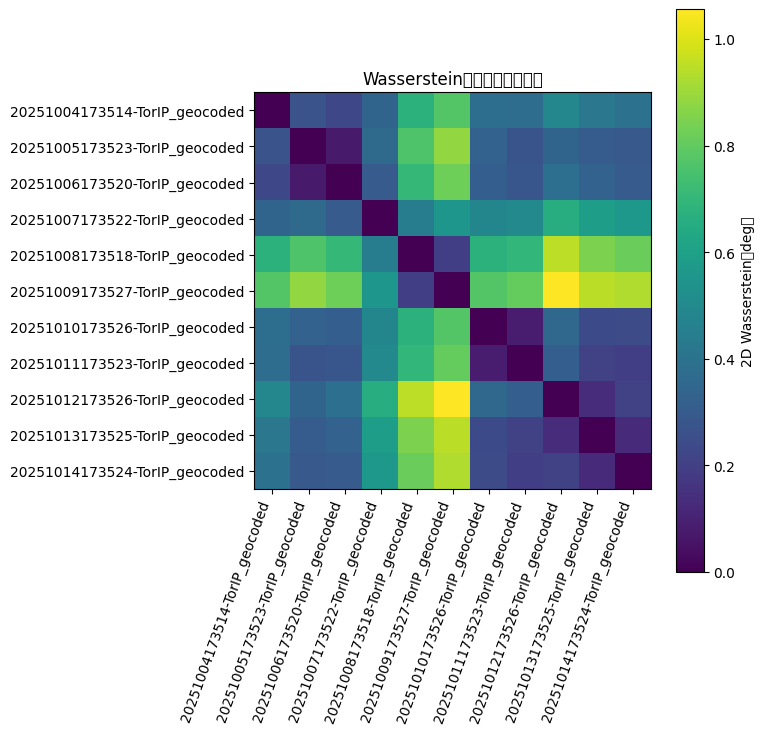

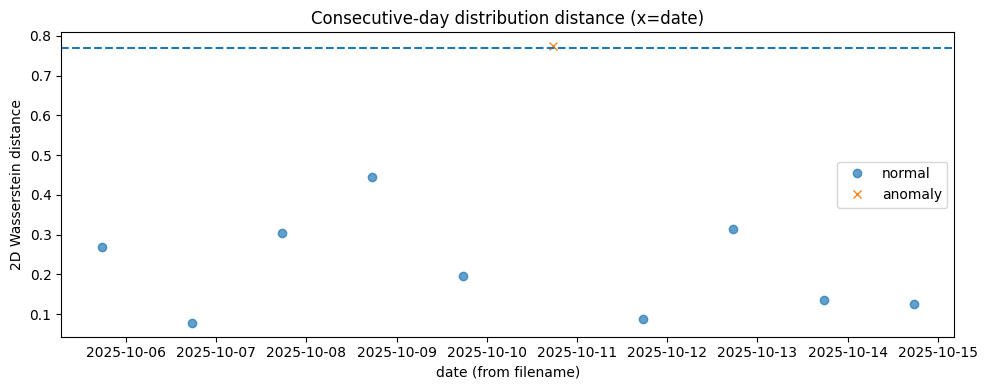

✅ 出力完了
   wasserstein_matrix.csv （距離行列CSV）
   wasserstein_files.txt （行列のファイル順）
   wasserstein_heatmap.png （距離行列ヒートマップPNG＋表示）
   wasserstein_timeseries.csv （隣接距離の時系列CSV）
   wasserstein_timeseries.png （隣接距離の時系列PNG＋表示）
⚠ 異常候補（日）:
  - 2025-10-10 17:35:26  file=20251010173526-TorIP_geocoded  dist=0.774351  z=3.54


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
ホワイトリスト16件の TorIP_geocoded.csv (ip,timestamp,lat,lng) を対象に：

(1) 全ファイル間の 2D Wasserstein 距離行列を作成
    - CSV: <PREFIX>_matrix.csv（見出し付き）
    - TXT: <PREFIX>_files.txt（行列のファイル順）
    - PNG: <PREFIX>_heatmap.png（plt.show() で表示）

(2) ファイル名の先頭14桁（YYYYMMDDhhmmss）を日時とみなしてソートし、
    隣接ペア間の 2D Wasserstein 距離の「時系列」を作成
    - CSV: <PREFIX>_timeseries.csv（date, file, distance, z）
    - PNG: <PREFIX>_timeseries.png（plt.show() で表示、|z|>Z_THR_TS を×マーカー）

(3) 起動直後に ./wasserstein_matrix.csv を安全削除（要望対応）

※ 2D Wasserstein は lat と lon の1次元WDを二乗和の平方根で合成
※ seaborn 不使用。matplotlib のみ
"""

# ========= 設定 =========
PREFIX   = "wasserstein"
UNIT     = "deg"       # "deg" or "km"（km換算したい場合は "km"）
MIN_ROWS = 1           # 各CSVで採用する最小有効行数

# 時系列の異常検知（距離のロバストZ）
Z_THR_TS = 3.5

# 対象ファイル（この16件以外は処理しない＝ホワイトリスト）
TARGET_FILES = [
    "20251003142418-TorIP_geocoded.csv",
    "20251003143810-TorIP_geocoded.csv",
    "20251003164852-TorIP_geocoded.csv",
    "20251003172946-TorIP_geocoded.csv",
    "20251003173524-TorIP_geocoded.csv",
    "20251004173514-TorIP_geocoded.csv",
    "20251005173523-TorIP_geocoded.csv",
    "20251006173520-TorIP_geocoded.csv",
    "20251007173522-TorIP_geocoded.csv",
    "20251008173518-TorIP_geocoded.csv",
    "20251009173527-TorIP_geocoded.csv",
    "20251010173526-TorIP_geocoded.csv",
    "20251011173523-TorIP_geocoded.csv",
    "20251012173526-TorIP_geocoded.csv",
    "20251013173525-TorIP_geocoded.csv",
    "20251014173524-TorIP_geocoded.csv",
]
# =======================

import os, sys, csv, math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager, rcParams
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import wasserstein_distance

# 日本語フォント（任意）
JP_FONT_CANDIDATES = ["Noto Sans CJK JP", "Noto Serif CJK JP", "IPAexGothic", "IPAPGothic", "TakaoGothic"]
def setup_japanese_font():
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in JP_FONT_CANDIDATES:
        if name in available:
            rcParams["font.family"] = "sans-serif"
            rcParams["font.sans-serif"] = [name]
            break
    rcParams["axes.unicode_minus"] = False

# 文字コードフォールバック
ENCODINGS = ("utf-8", "utf-8-sig", "cp932")
def open_with_fallback(path):
    last = None
    for enc in ENCODINGS:
        try:
            return open(path, "r", encoding=enc, newline="")
        except Exception as e:
            last = e
    try:
        return open(path, "r", newline="")
    except Exception:
        raise last or RuntimeError(f"cannot open {path}")

# ヘッダ自動判定
def row_has_header_like(cells):
    if len(cells) < 4:
        return True
    try:
        float((cells[2] or "").strip()); float((cells[3] or "").strip())
        return False
    except Exception:
        return True

# CSV → 有効 lat/lon 抽出
def load_valid_latlon(filepath):
    lats, lons = [], []
    with open_with_fallback(filepath) as f:
        rdr = csv.reader(f)
        first = next(rdr, None)
        if first is None:
            return np.empty(0), np.empty(0)
        use_header = row_has_header_like(first)
        rows_iter = rdr if use_header else [first] + list(rdr)
        for row in rows_iter:
            if len(row) < 4:
                continue
            lat_s = (row[2] or "").strip()
            lon_s = (row[3] or "").strip()
            if not lat_s or not lon_s:
                continue
            try:
                lat = float(lat_s); lon = float(lon_s)
                if math.isfinite(lat) and math.isfinite(lon):
                    lats.append(lat); lons.append(lon)
            except Exception:
                continue
    return np.array(lats, float), np.array(lons, float)

# 単位換算（deg→km）
def deg_to_km_scale(lat_values):
    phi = (float(np.median(lat_values)) if len(lat_values) else 0.0) * math.pi/180.0
    return 111.32, 111.32 * math.cos(phi)

# 2D Wasserstein（lat/lon の1次元WDを合成）
def composite_wasserstein_2d(lat_a, lon_a, lat_b, lon_b):
    if UNIT == "km":
        la_km, lo_km = deg_to_km_scale(np.concatenate([lat_a, lat_b]))
        lat_a = lat_a * la_km; lat_b = lat_b * la_km
        lon_a = lon_a * lo_km; lon_b = lon_b * lo_km
    d_lat = wasserstein_distance(lat_a, lat_b)
    d_lon = wasserstein_distance(lon_a, lon_b)
    return float(np.hypot(d_lat, d_lon))

# ロバストZ（時系列の距離に対して）
def robust_zscore(x: np.ndarray) -> np.ndarray:
    if x.size == 0:
        return np.zeros(0, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad == 0:
        return np.zeros_like(x, float)
    return 0.6745 * (x - med) / mad

# ファイル名先頭14桁 → (date, datetime_full)
def date_from_filename(fname: str):
    """
    'YYYYMMDDhhmmss-*.csv' から (日付, フルdatetime) を返す。
    """
    base = os.path.basename(fname)
    key = base.split("-")[0]
    if len(key) < 8:
        return None
    try:
        dt = datetime.strptime(key[:14], "%Y%m%d%H%M%S") if len(key) >= 14 else datetime.strptime(key[:8], "%Y%m%d")
        return dt.date(), dt
    except Exception:
        return None

def main():
    # 起動直後に ./wasserstein_matrix.csv を安全削除
    try:
        if os.path.exists("./wasserstein_matrix.csv"):
            os.remove("./wasserstein_matrix.csv")
            print("[INFO] removed: ./wasserstein_matrix.csv")
    except Exception as e:
        print(f"[WARN] cannot remove ./wasserstein_matrix.csv: {e}", file=sys.stderr)

    setup_japanese_font()

    # ホワイトリストのみ & 存在確認
    files_all = TARGET_FILES
    files = [f for f in files_all if os.path.exists(f)]
    missing = [f for f in files_all if not os.path.exists(f)]
    if missing:
        for m in missing:
            print(f"[WARN] missing: {m}", file=sys.stderr)
    if len(files) < 2:
        print("[ERROR] 処理対象のCSVが2つ未満です。", file=sys.stderr)
        return

    # 読み込み＆日付抽出
    records = []  # (date, datetime_full, fname, lats, lons)
    for f in files:
        d = date_from_filename(f)
        if d is None:
            print(f"[WARN] bad filename (no date): {f}", file=sys.stderr)
            continue
        day, dt_full = d
        lats, lons = load_valid_latlon(f)
        if len(lats) >= MIN_ROWS and len(lons) >= MIN_ROWS:
            records.append((day, dt_full, f, lats, lons))
        else:
            print(f"[WARN] 有効行不足: {f}  lat={len(lats)} lon={len(lons)}", file=sys.stderr)

    if len(records) < 2:
        print("[ERROR] 有効なファイルが2つ未満です。", file=sys.stderr)
        return

    # 日時で並べ替え
    records.sort(key=lambda t: t[1])
    file_list = [r[2] for r in records]
    base_names = [os.path.splitext(os.path.basename(f))[0] for f in file_list]
    n = len(records)

    # ---------- (1) 全ファイル間の距離行列 ----------
    dist = np.zeros((n, n), float)
    for i in range(n):
        for j in range(i + 1, n):
            lat_i, lon_i = records[i][3], records[i][4]
            lat_j, lon_j = records[j][3], records[j][4]
            d = composite_wasserstein_2d(lat_i, lon_i, lat_j, lon_j)
            dist[i, j] = dist[j, i] = d

    # 出力：行列CSV（見出し付き）＆順序リスト
    matrix_csv = f"{PREFIX}_matrix.csv"
    files_txt  = f"{PREFIX}_files.txt"
    try:
        if os.path.exists(matrix_csv):
            os.remove(matrix_csv)
    except Exception:
        pass

    with open(matrix_csv, "w", encoding="utf-8", newline="") as w:
        wr = csv.writer(w)
        wr.writerow([""] + base_names)
        for i, name in enumerate(base_names):
            wr.writerow([name] + [f"{x:.6f}" for x in dist[i]])

    with open(files_txt, "w", encoding="utf-8") as w:
        w.write("\n".join(file_list))

    # ヒートマップ（保存＋表示）
    fig = plt.figure(figsize=(max(6, n * 0.7), max(5, n * 0.7)))
    ax = plt.gca()
    im = ax.imshow(dist, aspect="equal", interpolation="nearest")
    cbar = plt.colorbar(im)
    cbar.set_label(f"2D Wasserstein（{UNIT}）")
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(base_names, rotation=70, ha="right")
    ax.set_yticklabels(base_names)
    ax.set_title("Wasserstein距離ヒートマップ")
    plt.tight_layout()
    out_png_matrix = f"{PREFIX}_heatmap.png"
    plt.savefig(out_png_matrix, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

    # ---------- (2) 隣接日の距離・時系列 ----------
    dates_dt = [r[1] for r in records]
    dist_vals = []
    right_files = []
    for i in range(1, n):
        latL, lonL = records[i-1][3], records[i-1][4]
        latR, lonR = records[i][3],  records[i][4]
        d = composite_wasserstein_2d(latL, lonL, latR, lonR)
        dist_vals.append(d)
        right_files.append(base_names[i])

    dates_series = np.array(dates_dt[1:], dtype=object)
    dist_vals = np.array(dist_vals, float)

    # ロバストZと閾線
    z = robust_zscore(dist_vals)
    is_anom = np.abs(z) > Z_THR_TS
    med = np.median(dist_vals)
    mad = np.median(np.abs(dist_vals - med))
    thr_line = med + (Z_THR_TS/0.6745)*mad if mad > 0 else med

    # CSV
    ts_csv = f"{PREFIX}_timeseries.csv"
    try:
        if os.path.exists(ts_csv):
            os.remove(ts_csv)
    except Exception:
        pass
    with open(ts_csv, "w", encoding="utf-8", newline="") as w:
        wr = csv.writer(w)
        wr.writerow(["date","file","distance","z"])
        for i in range(len(dist_vals)):
            wr.writerow([dates_series[i].strftime("%Y-%m-%d %H:%M:%S"),
                         right_files[i], f"{dist_vals[i]:.6f}", f"{z[i]:.3f}"])

    # プロット（保存＋表示）
    fig = plt.figure(figsize=(10, 4))
    ax  = plt.gca()
    idx_n = np.where(~is_anom)[0]; idx_a = np.where(is_anom)[0]
    ax.plot(dates_series[idx_n], dist_vals[idx_n], marker="o", linestyle="none", label="normal", alpha=0.7)
    ax.plot(dates_series[idx_a], dist_vals[idx_a], marker="x", linestyle="none", label="anomaly", alpha=0.95)
    ax.axhline(thr_line, linestyle="--")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")  # ★ 日付を縦向きに表示
    plt.xlabel("date (from filename)")
    plt.ylabel("2D Wasserstein distance")
    plt.title("Consecutive-day distribution distance (x=date)")
    plt.legend()
    plt.tight_layout()
    out_png_ts = f"{PREFIX}_timeseries.png"
    plt.savefig(out_png_ts, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

    # レポート
    print("✅ 出力完了")
    print("  ", matrix_csv,   "（距離行列CSV）")
    print("  ", files_txt,    "（行列のファイル順）")
    print("  ", out_png_matrix,"（距離行列ヒートマップPNG＋表示）")
    print("  ", ts_csv,       "（隣接距離の時系列CSV）")
    print("  ", out_png_ts,   "（隣接距離の時系列PNG＋表示）")
    if np.any(is_anom):
        print("⚠ 異常候補（日）:")
        for i in np.where(is_anom)[0]:
            print(f"  - {dates_series[i].strftime('%Y-%m-%d %H:%M:%S')}  file={right_files[i]}  dist={dist_vals[i]:.6f}  z={z[i]:.2f}")

if __name__ == "__main__":
    main()
